In [ ]:
!pip install transformers datasets huggingface_hub tensorboard==2.11
!sudo apt-get install git-lfs --yes
! pip install transformers[torch] -U
! pip install accelerate -U
!pip install wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 44.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-

In [ ]:
import json
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TextClassificationPipeline, pipeline
from huggingface_hub import HfFolder, notebook_login
import wget
import os
import pandas as pd
from datasets import Dataset, load_dataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [ ]:
#Logging in into Hugging Face
notebook_login()


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NameError: name 'torch' is not defined

In [ ]:
# Paths to the new dataset files
test_jsonl_path = "/content/drive/My Drive/dataset_with_n/arxiv_bloomz_test.jsonl"

In [ ]:
# Function to load a dataset from a JSONL file
def load_jsonl_to_dataset(jsonl_path):
    data = []
    with open(jsonl_path, 'r') as file:
        for line in file:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue  # Skip lines that are not valid JSON
    return data

In [ ]:
# Load datasets
test_data = load_jsonl_to_dataset(test_jsonl_path)

In [ ]:
def prepare_dataset(data, abstract = "abstract", machine_abstract = "machine_abstract"):
    examples = []
    labels = []

    # Append text and labels for human and machine texts
    for example in data:
        examples.append(example[abstract])
        labels.append(0)  # Human text label
        examples.append(example[machine_abstract])
        labels.append(1)  # Machine text label

    # Creating a dataset
    dataset = Dataset.from_dict({"text": examples, "labels": labels})

    return dataset

In [ ]:
# Prepare datasets
test_dataset = prepare_dataset(test_data)

In [ ]:
print("Size of the dataset:", len(test_dataset))

Size of the dataset: 1200


In [ ]:
# Load model and tokenizer
model_name = "andreas122001/bloomz-560m-academic-detector"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/324 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
# Initialize the TextClassificationPipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

In [ ]:
# Make predictions
# predictions = pipeline(test_dataset["text"])

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
test_dataset = test_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(test_dataset[0])
print(test_dataset[1])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic\nwaveforms describing the gravitational wave signal emitted by inspiralling and\ncoalescing binary black holes. We work within the Effective-One-Body (EOB)\nframework and propose a methodology for improving the current\n(waveform)implementations of this framework based on understanding, element by\nelement, the physics behind each feature of the waveform, and on systematically\ncomparing various EOB-based waveforms with ``exact'' waveforms obtained by\nnumerical relativity approaches. The present paper focuses on small-mass-ratio\nnon-spinning binary systems, which can be conveniently studied by\nRegge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed,\n3PN-accurate description of the inspiral waveform, (ii) a better description of\nradiation reaction during the plunge, (iii) a refined analytic expression for\nthe plunge waveform, (iv) an improved treatment of the matching between the\np

In [ ]:
print(test_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_test_dataset = test_dataset.to_pandas()
df_test_dataset['target_labels'] = df_test_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_test_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,We address the problem of constructing high-...,0,human-produced,human-produced
1,We present the first results for effective-one...,1,human-produced,machine-generated
2,We propose a pairing-based method for coolin...,0,human-produced,human-produced
3,We propose to cool fermionic atoms in optical ...,1,human-produced,machine-generated
4,Energetic feedback processes during the form...,0,human-produced,human-produced


In [ ]:
predicted_labels = df_test_dataset.predicted_labels.to_list()
true_labels = df_test_dataset.target_labels.to_list()

Confusion Matrix:
[[ 46 554]
 [  0 600]]


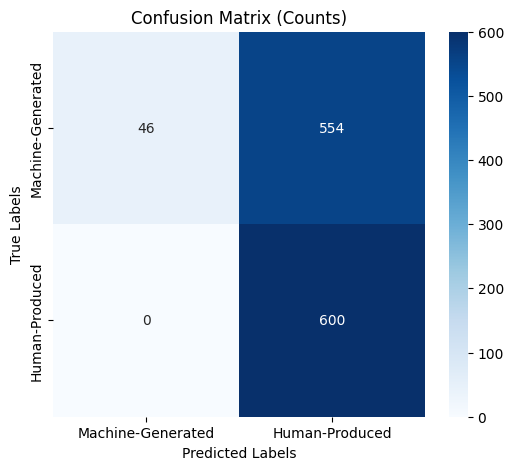

Confusion Matrix in Percentage:
[[  7.66666667  92.33333333]
 [  0.         100.        ]]


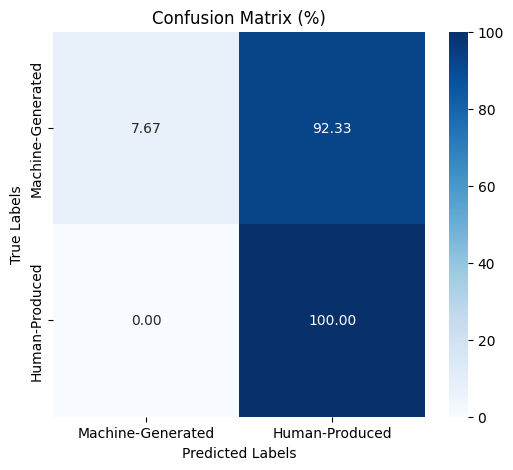

In [ ]:
# Plotting confusion matrix with counts
# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()

# Plotting confusion matrix with percentages
# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()

In [ ]:
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.5383
Precision: 1.0000
Recall: 0.0767


# Testing with Bloomz paraphrased

In [ ]:
# Paths to the new dataset files
bloomz_para_data_jsonl_path = "/content/drive/My Drive/dataset_with_n/arxiv_bloomz_paraphrased_filtered.jsonl"

In [ ]:
# Load datasets
bloomz_para_data = load_jsonl_to_dataset(bloomz_para_data_jsonl_path)

In [ ]:
# Prepare datasets
bloomz_para_dataset = prepare_dataset(bloomz_para_data)

In [ ]:
print("Size of the bloomz_para dataset:", len(bloomz_para_dataset))

Size of the bloomz_para dataset: 1200


In [ ]:
# Initialize the TextClassificationPipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Make predictions
# predictions = pipeline(test_dataset["text"])

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
bloomz_para_dataset = bloomz_para_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(bloomz_para_dataset[0])
print(bloomz_para_dataset[1])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': '  A rather non-standard quantum representation of the canonical commutation\nrelations of quantum mechanics systems, known as the polymer representation has\ngained some attention in recent years, due to its possible relation with Planck\nscale physics. In particular, this approach has been followed in a symmetric\nsector of loop quantum gravity known as loop quantum cosmology. Here we explore\ndifferent aspects of the relation between the ordinary Schroedinger theory and\nthe polymer description. The paper has two parts. In the first one, we derive\nthe polymer quantum mechanics starting from the ordinary Schroedinger theory\nand show that the polymer description arises as an appropriate limit. In the\nsecond part we consider the continuum limit of this theory, namely, the reverse\nprocess in which one starts from the discrete theory and tries to recover back\nthe ordinary Schroedinger quantum mechanics. We consider several examples of\ninterest, including the harmonic oscil

In [ ]:
print(bloomz_para_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_bloomz_para_dataset = bloomz_para_dataset.to_pandas()
df_bloomz_para_dataset['target_labels'] = df_bloomz_para_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_bloomz_para_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,A rather non-standard quantum representation...,0,human-produced,human-produced
1,The present work is devoted to the study of qu...,1,machine-generated,machine-generated
2,In this manuscript we investigate the capabi...,0,human-produced,human-produced
3,The Discrete Dipole Approximation (DDA) is use...,1,human-produced,machine-generated
4,The aim of the present paper is to provide a...,0,human-produced,human-produced


In [ ]:
predicted_labels = df_bloomz_para_dataset.predicted_labels.to_list()
true_labels = df_bloomz_para_dataset.target_labels.to_list()

Confusion Matrix:
[[ 46 554]
 [  0 600]]


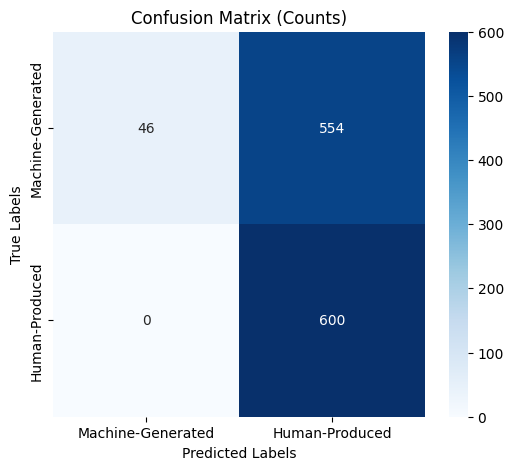

Confusion Matrix in Percentage:
[[  7.66666667  92.33333333]
 [  0.         100.        ]]


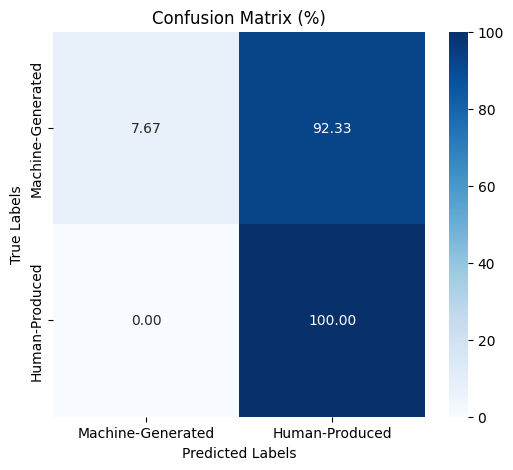

In [ ]:
# Plotting confusion matrix with counts
# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()

# Plotting confusion matrix with percentages
# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()

In [ ]:
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.5383
Precision: 1.0000
Recall: 0.0767


# Testing with chatgpt

In [ ]:
# Paths to the new dataset files
chatgpt_data_jsonl_path = "/content/drive/My Drive/dataset_with_n/arxiv_chatGPT_test.jsonl"

In [ ]:
# Load datasets
chatgpt_data = load_jsonl_to_dataset(chatgpt_data_jsonl_path)

In [ ]:
# Prepare datasets
chatgpt_dataset = prepare_dataset(chatgpt_data, 'human_text', 'machine_text')

In [ ]:
print("Size of the chatgpt dataset:", len(chatgpt_dataset))

Size of the chatgpt dataset: 1200


In [ ]:
# Initialize the TextClassificationPipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Make predictions
# predictions = pipeline(test_dataset["text"])

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
chatgpt_dataset = chatgpt_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(chatgpt_dataset[0])
print(chatgpt_dataset[1])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic\nwaveforms describing the gravitational wave signal emitted by inspiralling and\ncoalescing binary black holes. We work within the Effective-One-Body (EOB)\nframework and propose a methodology for improving the current\n(waveform)implementations of this framework based on understanding, element by\nelement, the physics behind each feature of the waveform, and on systematically\ncomparing various EOB-based waveforms with ``exact'' waveforms obtained by\nnumerical relativity approaches. The present paper focuses on small-mass-ratio\nnon-spinning binary systems, which can be conveniently studied by\nRegge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed,\n3PN-accurate description of the inspiral waveform, (ii) a better description of\nradiation reaction during the plunge, (iii) a refined analytic expression for\nthe plunge waveform, (iv) an improved treatment of the matching between the\np

In [ ]:
print(chatgpt_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_chatgpt_dataset = chatgpt_dataset.to_pandas()
df_chatgpt_dataset['target_labels'] = df_chatgpt_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_chatgpt_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,We address the problem of constructing high-...,0,human-produced,human-produced
1,"In this work, we present a novel approach to t...",1,machine-generated,machine-generated
2,We propose a pairing-based method for coolin...,0,human-produced,human-produced
3,We present our work on pairing based cooling o...,1,machine-generated,machine-generated
4,Energetic feedback processes during the form...,0,human-produced,human-produced


In [ ]:
predicted_labels = df_chatgpt_dataset.predicted_labels.to_list()
true_labels = df_chatgpt_dataset.target_labels.to_list()

Confusion Matrix:
[[600   0]
 [  0 600]]


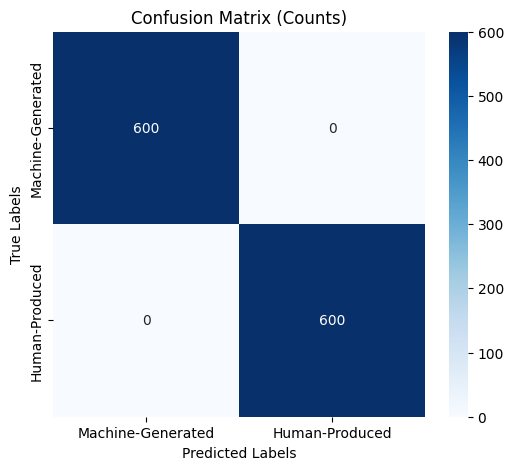

Confusion Matrix in Percentage:
[[100.   0.]
 [  0. 100.]]


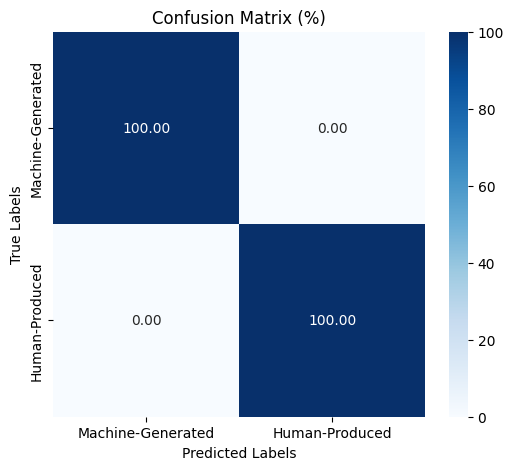

In [ ]:
# Plotting confusion matrix with counts
# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()

# Plotting confusion matrix with percentages
# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()

In [ ]:
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


# Testing with cohere

In [ ]:
# Paths to the new dataset files
cohere_data_jsonl_path = "/content/drive/My Drive/dataset_with_n/arxiv_cohere_test.jsonl"

In [ ]:
# Load datasets
cohere_data = load_jsonl_to_dataset(cohere_data_jsonl_path)

In [ ]:
# Prepare datasets
cohere_dataset = prepare_dataset(cohere_data, 'human_text', 'machine_text')

In [ ]:
print("Size of the cohere dataset:", len(cohere_dataset))

Size of the cohere dataset: 1200


In [ ]:
# Initialize the TextClassificationPipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Make predictions
# predictions = pipeline(test_dataset["text"])

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
cohere_dataset = cohere_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(cohere_dataset[0])
print(cohere_dataset[1])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic\nwaveforms describing the gravitational wave signal emitted by inspiralling and\ncoalescing binary black holes. We work within the Effective-One-Body (EOB)\nframework and propose a methodology for improving the current\n(waveform)implementations of this framework based on understanding, element by\nelement, the physics behind each feature of the waveform, and on systematically\ncomparing various EOB-based waveforms with ``exact'' waveforms obtained by\nnumerical relativity approaches. The present paper focuses on small-mass-ratio\nnon-spinning binary systems, which can be conveniently studied by\nRegge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed,\n3PN-accurate description of the inspiral waveform, (ii) a better description of\nradiation reaction during the plunge, (iii) a refined analytic expression for\nthe plunge waveform, (iv) an improved treatment of the matching between the\np

In [ ]:
print(cohere_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_cohere_dataset= cohere_dataset.to_pandas()
df_cohere_dataset['target_labels'] = df_cohere_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_cohere_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,We address the problem of constructing high-...,0,human-produced,human-produced
1,\nWe study the effects of small-mass-ratio on ...,1,human-produced,machine-generated
2,We propose a pairing-based method for coolin...,0,human-produced,human-produced
3,\n\nWe consider a recently proposed method to ...,1,machine-generated,machine-generated
4,Energetic feedback processes during the form...,0,human-produced,human-produced


In [ ]:
predicted_labels = df_cohere_dataset.predicted_labels.to_list()
true_labels = df_cohere_dataset.target_labels.to_list()

Confusion Matrix:
[[147 453]
 [  0 600]]


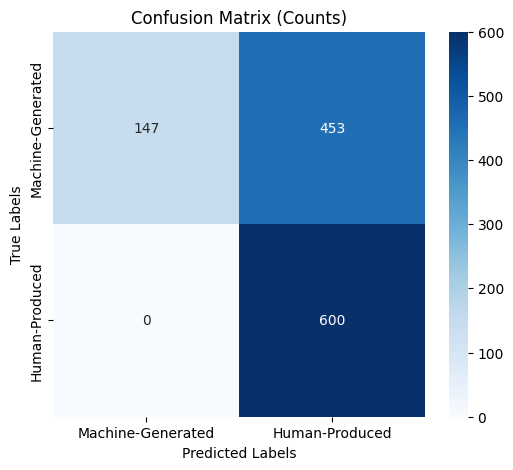

Confusion Matrix in Percentage:
[[ 24.5  75.5]
 [  0.  100. ]]


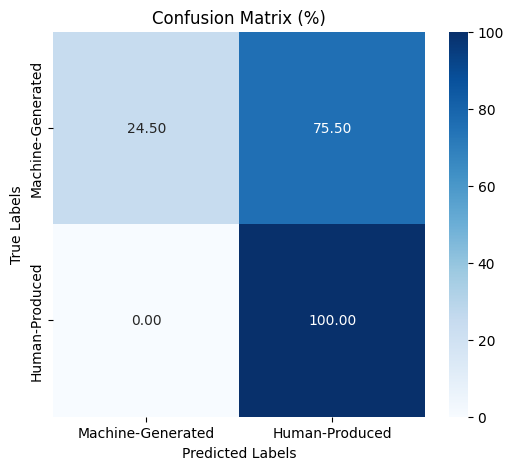

In [ ]:
# Plotting confusion matrix with counts
# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()

# Plotting confusion matrix with percentages
# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()

In [ ]:
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.6225
Precision: 1.0000
Recall: 0.2450


# Testing with davinci

In [ ]:
# Paths to the new dataset files
davinci_data_jsonl_path = "/content/drive/My Drive/dataset_with_n/arxiv_davinci_test.jsonl"

In [ ]:
# Load datasets
davinci_data = load_jsonl_to_dataset(davinci_data_jsonl_path)

In [ ]:
# Prepare datasets
davinci_dataset = prepare_dataset(davinci_data, 'human_text', 'machine_text')

In [ ]:
print("Size of the davinci dataset:", len(davinci_dataset))

Size of the davinci dataset: 1200


In [ ]:
# Initialize the TextClassificationPipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Make predictions
# predictions = pipeline(test_dataset["text"])

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
davinci_dataset = davinci_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(davinci_dataset[0])
print(davinci_dataset[1])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': '  We use new and published near-IR spectra, with synthetic spectra, to derive\nphysical properties of three of the latest-type T dwarfs. A new R~1700 spectrum\nof the T7.5 dwarf HD 3651B, with existing data, allows a detailed comparison to\nthe well-studied and very similar dwarf, Gl 570D. We find that HD 3651B has\nboth higher gravity and metallicity than Gl 570D, with Teff=820-830K, log g=\n5.4-5.5, [m/H]= +0.2 and Kzz=10^4cm^2/s. Its age is 8-12 Gyr and its implied\nmass is 60-70 M_Jup. We perform a similar analyis of the T8 and T7.5 dwarfs\n2MASS J09393548-2448279 and 2MASS J11145133-2618235 using published data,\ncomparing them to the well-studied T8, 2MASS J04151954-0935066. We find that\nthe two dwarfs have the same Teff as the reference dwarf, and similar\ngravities, but lower metallicities. The parameters are Teff=725-775K and [m/H]=\n-0.3; log g=5.3-5.45 for 2MASS J09393548-2448279 and log g=5.0-5.3 for 2MASS\nJ11145133- 261823. The age and mass are ~10Gyr and 60M_J

In [ ]:
print(davinci_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_davinci_dataset= davinci_dataset.to_pandas()
df_davinci_dataset['target_labels'] = df_davinci_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_davinci_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,"We use new and published near-IR spectra, wi...",0,human-produced,human-produced
1,We have studied the physical and spectral char...,1,human-produced,machine-generated
2,Ongoing accretion onto galactic disks has be...,0,human-produced,human-produced
3,This article explores the concept of galactic ...,1,machine-generated,machine-generated
4,The spectrum of meson and diquark excitation...,0,human-produced,human-produced


In [ ]:
predicted_labels = df_davinci_dataset.predicted_labels.to_list()
true_labels = df_davinci_dataset.target_labels.to_list()

Confusion Matrix:
[[172 428]
 [  0 600]]


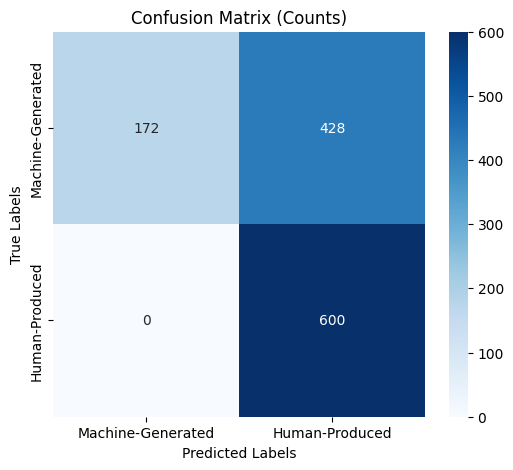

Confusion Matrix in Percentage:
[[ 28.66666667  71.33333333]
 [  0.         100.        ]]


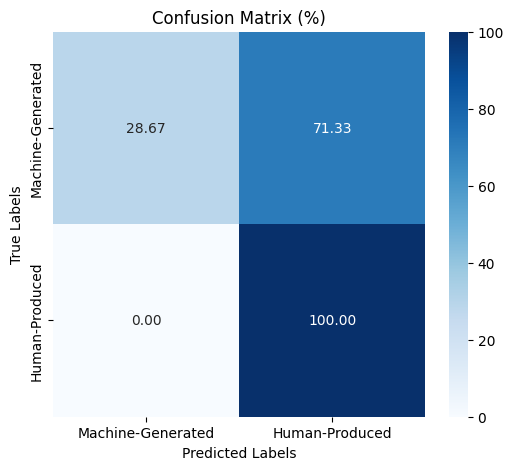

In [ ]:
# Plotting confusion matrix with counts
# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()

# Plotting confusion matrix with percentages
# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()

In [ ]:
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.6433
Precision: 1.0000
Recall: 0.2867


# Testing with flant5

In [ ]:
# Paths to the new dataset files
flant5_data_jsonl_path = "/content/drive/My Drive/dataset_with_n/arxiv_flant5_test.jsonl"

In [ ]:
# Load datasets
flant5_data = load_jsonl_to_dataset(flant5_data_jsonl_path)

In [ ]:
# Prepare datasets
flant5_dataset = prepare_dataset(flant5_data, 'human_text', 'machine_text')

In [ ]:
print("Size of the flant5 dataset:", len(flant5_dataset))

Size of the flant5 dataset: 1200


In [ ]:
# Initialize the TextClassificationPipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Make predictions
# predictions = pipeline(test_dataset["text"])

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
flant5_dataset = flant5_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(flant5_dataset[0])
print(flant5_dataset[1])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic\nwaveforms describing the gravitational wave signal emitted by inspiralling and\ncoalescing binary black holes. We work within the Effective-One-Body (EOB)\nframework and propose a methodology for improving the current\n(waveform)implementations of this framework based on understanding, element by\nelement, the physics behind each feature of the waveform, and on systematically\ncomparing various EOB-based waveforms with ``exact'' waveforms obtained by\nnumerical relativity approaches. The present paper focuses on small-mass-ratio\nnon-spinning binary systems, which can be conveniently studied by\nRegge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed,\n3PN-accurate description of the inspiral waveform, (ii) a better description of\nradiation reaction during the plunge, (iii) a refined analytic expression for\nthe plunge waveform, (iv) an improved treatment of the matching between the\np

In [ ]:
print(flant5_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_flant5_dataset= flant5_dataset.to_pandas()
df_flant5_dataset['target_labels'] = df_flant5_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_flant5_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,We address the problem of constructing high-...,0,human-produced,human-produced
1,The paper presents the first faithful effectiv...,1,human-produced,machine-generated
2,We propose a pairing-based method for coolin...,0,human-produced,human-produced
3,The cooling of Fermi gases is a challenging pr...,1,machine-generated,machine-generated
4,Energetic feedback processes during the form...,0,human-produced,human-produced


In [ ]:
predicted_labels = df_flant5_dataset.predicted_labels.to_list()
true_labels = df_flant5_dataset.target_labels.to_list()

Confusion Matrix:
[[423 177]
 [  0 600]]


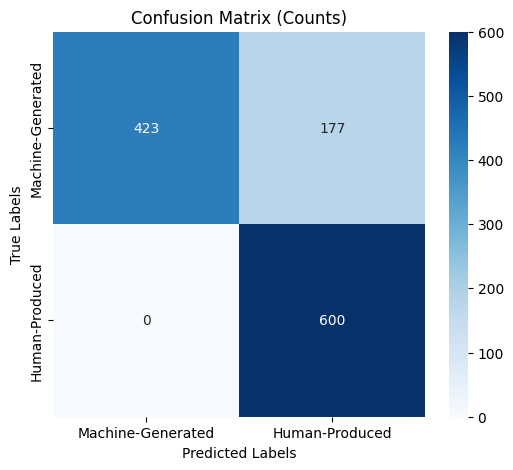

Confusion Matrix in Percentage:
[[ 70.5  29.5]
 [  0.  100. ]]


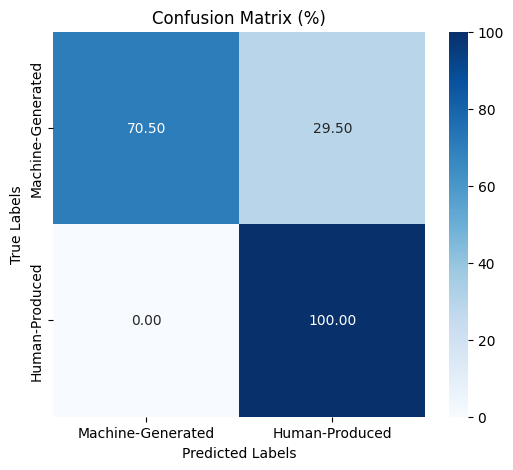

In [ ]:
# Plotting confusion matrix with counts
# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()

# Plotting confusion matrix with percentages
# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()

In [ ]:
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8525
Precision: 1.0000
Recall: 0.7050
